### importing libraries

In [1]:
import os
import numpy as np
import glob
import cv2
import random
import pathlib
import matplotlib.pyplot as plt
from pprint import pprint
import torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms 
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from PIL import Image

In [2]:
from torch.utils.data import Dataset
from tqdm import tqdm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
torch.cuda.empty_cache() 

In [1]:
!nvidia-smi

Sun Apr 10 15:25:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.47       Driver Version: 472.47       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8    12W /  N/A |   1660MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
lr = 1e-4
batch_size = 16
img_height = 256
img_width = 256
pin_memory = True

train_img_dir = r'C:/Users/utkar/Desktop/ML/pytorch/image segmentation/SkinCancerDataset/train/images'
train_mask_dir = r'C:/Users/utkar/Desktop/ML/pytorch/image segmentation/SkinCancerDataset/train/mask'
val_img_dir = r'C:/Users/utkar/Desktop/ML/pytorch/image segmentation/SkinCancerDataset/test/images'
val_mask_dir = r'C:/Users/utkar/Desktop/ML/pytorch/image segmentation/SkinCancerDataset/test/mask'

In [7]:
# dataset source: https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification

class ISDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_transform, mask_transform):
        super(ISDataset, self)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.img = os.listdir(img_dir)
        
    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img[index])
        mask_path = os.path.join(self.mask_dir, self.img[index].replace('.jpg', '_mask.png'))
        img = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('L'))
        
        img = self.img_transform(img)
        mask = self.mask_transform(mask)
            
        return img, mask

In [8]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize([0, 0, 0], [1, 1, 1]),
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize([0], [1]),
])

train_ds = ISDataset(
    img_dir=train_img_dir,
    mask_dir=train_mask_dir,
    img_transform=img_transform,
    mask_transform=mask_transform
)

val_ds = ISDataset(
    img_dir=val_img_dir,
    mask_dir=val_mask_dir,
    img_transform=img_transform,
    mask_transform=mask_transform
)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    pin_memory=pin_memory,
    shuffle=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    pin_memory=pin_memory,
    shuffle=False
)

In [9]:
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_c)
    )
    return conv

In [10]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv1 = double_conv(3, 64)
        self.down_conv2 = double_conv(64, 128)
        self.down_conv3 = double_conv(128, 256)
        self.down_conv4 = double_conv(256, 512)
        self.down_conv5 = double_conv(512, 1024)
        
        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2)
        
        self.up_conv_1 = double_conv(1024, 512)
        
        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2)
        
        self.up_conv_2 = double_conv(512, 256)
        
        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2)
        
        self.up_conv_3 = double_conv(256, 128)
        
        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2)
        
        self.up_conv_4 = double_conv(128, 64)
        
        self.out = nn.Conv2d(64, 1, kernel_size=1)
        
    def forward(self, img):
        # encoding
        x1 = self.down_conv1(img)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv4(x6)
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv5(x8)
        
        # decoding
        x = self.up_trans_1(x9)
        x = self.up_conv_1(torch.concat([x, x7], 1))
        x = self.up_trans_2(x)
        x = self.up_conv_2(torch.concat([x, x5], 1))
        x = self.up_trans_3(x)
        x = self.up_conv_3(torch.concat([x, x3], 1))
        x = self.up_trans_4(x)
        x = self.up_conv_4(torch.concat([x, x1], 1))
        x = self.out(x)
        
        return x

In [11]:
model = Unet().to(device)

In [12]:
x = torch.rand((1, 3, 256, 256))
print(x.shape)

torch.Size([1, 3, 256, 256])


In [13]:
y = model(x.to(device))
y.shape

torch.Size([1, 1, 256, 256])

In [14]:
pprint(torchinfo.summary(model, input_size=(1, 3, 256, 256)))

Layer (type:depth-idx)                   Output Shape              Param #
Unet                                     --                        --
├─Sequential: 1-1                        [1, 64, 256, 256]         --
│    └─Conv2d: 2-1                       [1, 64, 256, 256]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 256, 256]         128
│    └─ReLU: 2-3                         [1, 64, 256, 256]         --
│    └─Conv2d: 2-4                       [1, 64, 256, 256]         36,928
│    └─ReLU: 2-5                         [1, 64, 256, 256]         --
│    └─BatchNorm2d: 2-6                  [1, 64, 256, 256]         128
├─MaxPool2d: 1-2                         [1, 64, 128, 128]         --
├─Sequential: 1-3                        [1, 128, 128, 128]        --
│    └─Conv2d: 2-7                       [1, 128, 128, 128]        73,856
│    └─BatchNorm2d: 2-8                  [1, 128, 128, 128]        256
│    └─ReLU: 2-9                         [1, 128, 128, 128]        --
│

In [15]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [16]:
def check_acc(loader, model, device='cuda'):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)   # returns product of the values in tensor
            dice_score += (2*(preds*y).sum())/((preds + y).sum()+1e-8)
            
    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()
            

In [17]:
scaler = torch.cuda.amp.GradScaler()   # to avoid vanishing gradient problem

In [18]:
epochs = 5

for epoch in range(epochs):
    # training
    loop = tqdm(train_loader)
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device)
        target = targets.float().to(device)
        
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, target)
        
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # update tqdm loop
        loop.set_postfix(loss=loss.item())
        # checcking accuracy
        check_acc(val_loader, model, device=device)
    print(f'epoch {epoch}')
        

  0%|▏                                                                 | 1/501 [02:56<24:27:45, 176.13s/it, loss=0.714]

Got 33810603/131072000 with acc 25.80
Dice score: 0.41024067997932434


  0%|▎                                                                 | 2/501 [05:52<24:24:28, 176.09s/it, loss=0.622]

Got 33810603/131072000 with acc 25.80
Dice score: 0.41024067997932434


  1%|▍                                                                  | 3/501 [08:42<24:00:40, 173.58s/it, loss=0.56]

Got 33810603/131072000 with acc 25.80
Dice score: 0.41024067997932434


  1%|▌                                                                 | 4/501 [11:34<23:50:51, 172.74s/it, loss=0.538]

Got 33810603/131072000 with acc 25.80
Dice score: 0.41024067997932434


  1%|▋                                                                 | 5/501 [14:25<23:44:33, 172.33s/it, loss=0.452]

Got 33810603/131072000 with acc 25.80
Dice score: 0.41024067997932434


  1%|▋                                                                 | 5/501 [15:54<26:17:18, 190.80s/it, loss=0.426]


KeyboardInterrupt: 

In [ ]:
for data, targets in train_loader:
    print('inside')

In [ ]:
print(train_loader.dataset)

In [ ]:
a, b = train_loader.dataset[0]
n = 0

for a, b in train_loader.dataset:
    plt.imshow(a.permute(1, 2, 0), cmap='gray')
    fig = plt.figure(figsize=(10, 5))
    fig.add_subplot(1, 2, 2)
    plt.imshow(b.permute(1, 2, 0), cmap='gray')
    plt.show()
    n += 1
    if n == 5:
        break

1006
target


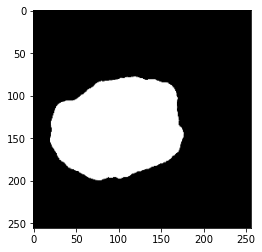

predicted


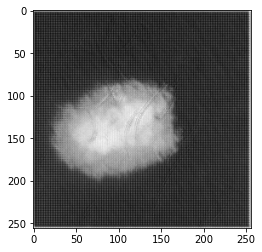

image


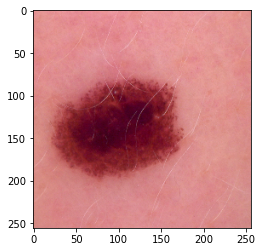

In [35]:
a = 0
b = np.random.randint(0, 2000)
print(b)
for img, mask in val_ds:
    a += 1
    if a == b:
        img1 = img.unsqueeze(0).to(device)
        #rint(img1.shape)
        mask_m = model(img1)
        #rint(mask_m.shape)
        print('target')
        plt.imshow(mask.permute(1, 2, 0), cmap='gray')
        plt.show()
        mask_m = torch.squeeze(mask_m)
        mask_m = mask_m.unsqueeze(1).permute(0, 2, 1).cpu().detach().numpy()
        print('predicted')
        plt.imshow(mask_m, cmap='gray')
        plt.show()
        print('image')
        plt.imshow(img.permute(1, 2, 0))
        plt.show()
        break
